In [1]:
from __future__ import absolute_import, division, print_function
from tensorflow.keras import Model, layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist

rng = np.random

### Loading and Preprocessing of Data

In [2]:
import tensorflow as tf

# Read data from directory containing separate directories for each label value - anger, fear, happiness, sadness, surprise
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    validation_split=0.2,     # 80/20 split
    subset="training",
    seed=42,                  # ensures same split every run
    label_mode="int",
    image_size=(48, 48),      # 
    color_mode="grayscale",   # or "rgb"
    batch_size=None,          # important: gives Numpy-like tensors
    shuffle=True              # shuffle!!
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode="int",
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=None # on iteration  gives one image at time
    # no shuffle!
)

class_names = train_ds.class_names

Found 59099 files belonging to 5 classes.
Using 47280 files for training.
Found 59099 files belonging to 5 classes.
Using 11819 files for validation.


In [3]:
# Convert data into Numpy arrays
# train data
x_train = []
y_train = []

for img, label in train_ds:
    x_train.append(img.numpy()) # tensor -> numpy array
    y_train.append(label.numpy())

x_train = np.array(x_train)
y_train = np.array(y_train)

# test data
x_test = []
y_test = []

for img, label in test_ds:
    x_test.append(img.numpy())
    y_test.append(label.numpy())

# right now x_train is a list of NumPy arrays, y_train is a list of integers

x_test = np.array(x_test)
y_test = np.array(y_test)

# x_train is two dimensional NumPy array, y_train is a one dimensional NumPy array

In [ ]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

In [ ]:
# ---------------------------------------------------------
# 4. Create tf.data Datasets
# ---------------------------------------------------------
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

ds_train = ds_train.shuffle(10000).batch(128).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
# ---------------------------------------------------------
# 5. Build the model
# ---------------------------------------------------------
model = tf.keras.Sequential([
    tf.keras.Input(shape=(48, 48, 1)),   # include channel for grayscale
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # adjust number of classes if needed
])

In [ ]:
# ---------------------------------------------------------
# 6. Compile the model
# ---------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
# ---------------------------------------------------------
# 7. Train
# ---------------------------------------------------------
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

accuracy = np.mean(predicted_classes == y_test)
print("Accuracy:", accuracy)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# How many images you want to visualize
n_images = 5

# Pick the first n images from your test set
test_images = x_test[:n_images]
test_labels = y_test[:n_images]

# Get predictions from your model
predictions = model.predict(test_images)

# If you want class names (folder names)
class_names = train_ds.class_names
print("Classes:", class_names)

for i in range(n_images):
    img = test_images[i]

    # Remove channel dimension if grayscale
    if img.shape[-1] == 1:
        img = img.reshape(48, 48)

    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    plt.axis("off")
    plt.show()

    predicted = np.argmax(predictions[i])
    actual = test_labels[i]

    print(f"Predicted class: {predicted}  ({class_names[predicted]})")
    print(f"Actual class:     {actual}  ({class_names[actual]})")
    print("-" * 40)


## Katse mõelda

In [14]:
from __future__ import absolute_import, division, print_function
from tensorflow.keras import Model, layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist

rng = np.random

## Loading and Preprocessing of Data

In [15]:
import tensorflow as tf

# Read data from directory containing separate directories for each label value - anger, fear, happiness, sadness, surprise
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    validation_split=0.2,     # 80/20 split
    subset="training",
    seed=42,                  # ensures same split every run
    label_mode="int",
    image_size=(48, 48),      # 
    color_mode="grayscale",   # or "rgb"
    batch_size=None,          # important: gives Numpy-like tensors
    shuffle=True              # shuffle!!
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode="int",
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=None # on iteration  gives one image at time
    # no shuffle!
)

class_names = train_ds.class_names
number_of_classes = 5

Found 59099 files belonging to 5 classes.
Using 47280 files for training.
Found 59099 files belonging to 5 classes.
Using 11819 files for validation.


In [16]:
train_ds = train_ds.shuffle(10000).batch(128).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(128).prefetch(tf.data.AUTOTUNE)

## Neural Network with dense layers

This is a dense network, meaning every neuron is connected to every neuron in the next layer. For a dense network the flattening of images before fitting the model is required. Dense network don't work well on (not very simple) images.

### Building the model

In [17]:
# ---------------------------------------------------------
# 5. Build the model
# ---------------------------------------------------------
model = tf.keras.Sequential([
    tf.keras.Input(shape=(48, 48, 1)),   # include channel for grayscale
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # adjust number of classes if needed
])

In [18]:
# ---------------------------------------------------------
# 6. Compile the model
# ---------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [19]:
# ---------------------------------------------------------
# 7. Train
# ---------------------------------------------------------
model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
)

Epoch 1/7
370/370 ━━━━━━━━━━━━━━━━━━━━ 148s 314ms/step - loss: 49.0067 - sparse_categorical_accuracy: 0.2605 - val_loss: 9.5595 - val_sparse_categorical_accuracy: 0.2249
Epoch 2/7
370/370 ━━━━━━━━━━━━━━━━━━━━ 51s 114ms/step - loss: 6.3061 - sparse_categorical_accuracy: 0.2988 - val_loss: 3.8457 - val_sparse_categorical_accuracy: 0.2750
Epoch 3/7
370/370 ━━━━━━━━━━━━━━━━━━━━ 50s 114ms/step - loss: 3.7242 - sparse_categorical_accuracy: 0.3122 - val_loss: 2.6845 - val_sparse_categorical_accuracy: 0.3662
Epoch 4/7
370/370 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - loss: 2.6347 - sparse_categorical_accuracy: 0.3270 - val_loss: 1.6223 - val_sparse_categorical_accuracy: 0.3697
Epoch 5/7
370/370 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - loss: 1.7019 - sparse_categorical_accuracy: 0.3590 - val_loss: 1.8437 - val_sparse_categorical_accuracy: 0.3322
Epoch 6/7
370/370 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - loss: 1.5923 - sparse_categorical_accuracy: 0.3719 - val_loss: 1.4801 - val_sparse_categorical_accurac

In [9]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

accuracy = np.mean(predicted_classes == y_test)
print("Accuracy:", accuracy)

NameError: name 'x_test' is not defined

In [20]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 1.7811 - sparse_categorical_accuracy: 0.2997
Test loss: 1.7736 accuracy: 0.3091


### Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


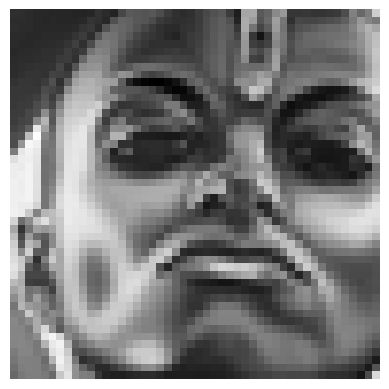

Predicted class: 4 (Suprise)
Actual class:     0 (Angry)
----------------------------------------


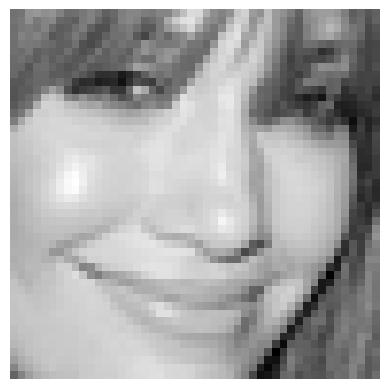

Predicted class: 4 (Suprise)
Actual class:     2 (Happy)
----------------------------------------


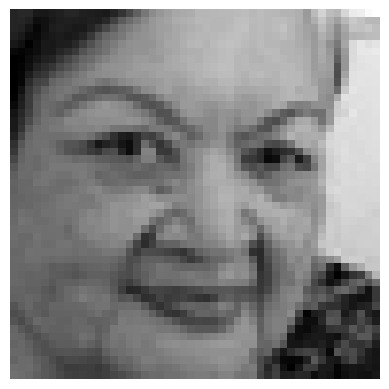

Predicted class: 2 (Happy)
Actual class:     2 (Happy)
----------------------------------------


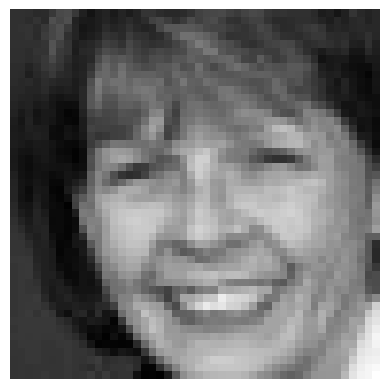

Predicted class: 2 (Happy)
Actual class:     2 (Happy)
----------------------------------------


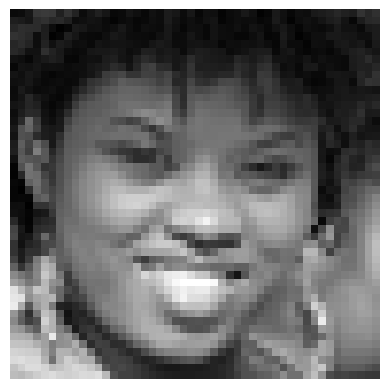

Predicted class: 2 (Happy)
Actual class:     2 (Happy)
----------------------------------------


In [22]:
# 1. Take one batch from the test dataset
images, labels = next(iter(test_ds))

# 2. Choose how many to show
n_images = 5

# 3. Run predictions on this batch
predictions = model.predict(images[:n_images])

# 4. Class names (folder names)
print("Classes:", class_names)

# 5. Visualize
for i in range(n_images):
    img = images[i].numpy()   # convert tensor → numpy
    label = labels[i].numpy()

    # Remove (48,48,1) → (48,48) for grayscale display
    if img.shape[-1] == 1:
        img = img.reshape(48, 48)

    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

    predicted = np.argmax(predictions[i])

    print(f"Predicted class: {predicted} ({class_names[predicted]})")
    print(f"Actual class:     {label} ({class_names[label]})")
    print("-" * 40)

## Convolutional neural network (CNN)

This network contains convolutional layers (Conv2D). It scans the image with small “windows” called kernels or filters to detect patterns

### Building the model

In [25]:
number_of_classes = 5

In [26]:
model = tf.keras.Sequential([

    # --- Convolution blocks ---
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(),
    # 32: number of filters -> 32 different pattern detectors
    # (3×3) = kernel (=filter) size in pixels - like a (3×3) window
    # padding='same' : 48×48 input → 48×48 output
    # MaxPooling : reduces image size by taking the maximum value in each 3x3 window
    

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    # --- Dense layers ---
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')
])

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,269 (2.61 MB)

 Trainable params: 683,269 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6
)

Epoch 1/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 78s 185ms/step - accuracy: 0.3444 - loss: 3.6994 - val_accuracy: 0.5000 - val_loss: 1.2175
Epoch 2/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 82s 201ms/step - accuracy: 0.5087 - loss: 1.1989 - val_accuracy: 0.5604 - val_loss: 1.0826
Epoch 3/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 79s 192ms/step - accuracy: 0.5734 - loss: 1.0568 - val_accuracy: 0.5842 - val_loss: 1.0347
Epoch 4/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 75s 179ms/step - accuracy: 0.6220 - loss: 0.9534 - val_accuracy: 0.6217 - val_loss: 0.9551
Epoch 5/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 76s 183ms/step - accuracy: 0.6653 - loss: 0.8530 - val_accuracy: 0.6726 - val_loss: 0.8524
Epoch 6/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 76s 183ms/step - accuracy: 0.7115 - loss: 0.7407 - val_accuracy: 0.6891 - val_loss: 0.8337
Epoch 7/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 83s 199ms/step - accuracy: 0.7456 - loss: 0.6491 - val_accuracy: 0.7262 - val_loss: 0.7523
Epoch 8/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 90s 222ms/step - accuracy: 0.7777 - loss: 0

In [29]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.7901 - loss: 0.6690
Test loss: 0.6421 accuracy: 0.7970


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


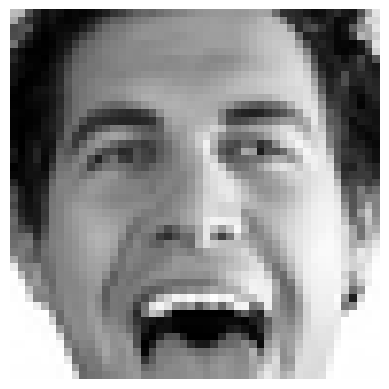

Predicted: 1 (Fear)
Actual:    1 (Fear)
----------------------------------------


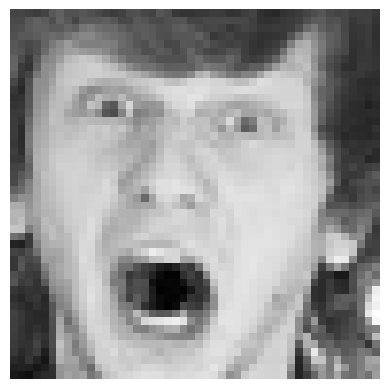

Predicted: 1 (Fear)
Actual:    1 (Fear)
----------------------------------------


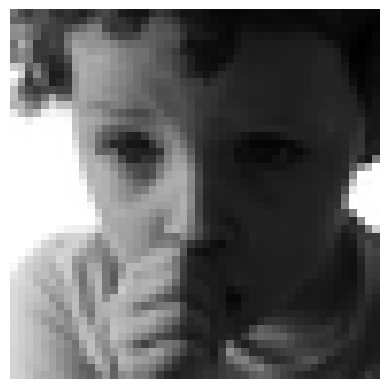

Predicted: 3 (Sad)
Actual:    3 (Sad)
----------------------------------------


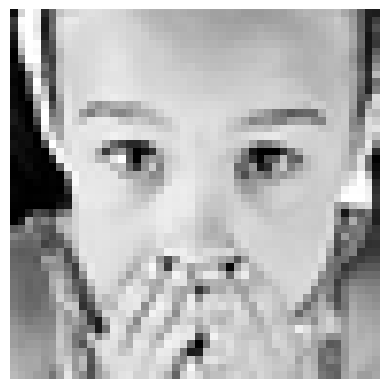

Predicted: 1 (Fear)
Actual:    1 (Fear)
----------------------------------------


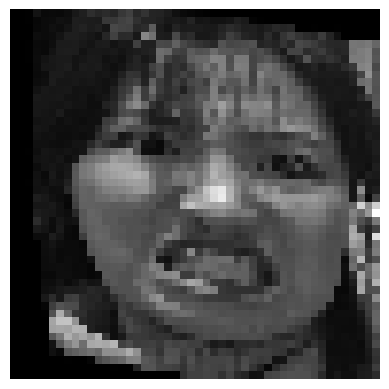

Predicted: 3 (Sad)
Actual:    0 (Angry)
----------------------------------------


In [30]:
images, labels = next(iter(test_ds))
n_images = 5

preds = model.predict(images[:n_images])

for i in range(n_images):
    img = images[i].numpy()
    if img.shape[-1] == 1:
        img = img.reshape(48,48)
    
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    
    predicted = np.argmax(preds[i])
    actual = labels[i].numpy()
    
    print(f"Predicted: {predicted} ({class_names[predicted]})")
    print(f"Actual:    {actual} ({class_names[actual]})")
    print("-"*40)

In [ ]:
num_classes = 5
num_features = 2304 # data features (img shape: 48*48).

learning_rate = 0.001
training_steps = 1000
batch_size = 256
display_step = 100

n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 64 # 2nd layer number of neurons.

In [31]:
model2 = tf.keras.Sequential([

    # --- Convolution blocks ---
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    # --- Dense layers ---
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')
])

In [32]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 609,029 (2.32 MB)

 Trainable params: 609,029 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6
)

Epoch 1/6
370/370 ━━━━━━━━━━━━━━━━━━━━ 71s 169ms/step - accuracy: 0.8458 - loss: 0.4015 - val_accuracy: 0.8042 - val_loss: 0.6238
Epoch 2/6
370/370 ━━━━━━━━━━━━━━━━━━━━ 70s 168ms/step - accuracy: 0.8632 - loss: 0.3603 - val_accuracy: 0.8177 - val_loss: 0.6031
Epoch 3/6
370/370 ━━━━━━━━━━━━━━━━━━━━ 92s 226ms/step - accuracy: 0.8734 - loss: 0.3275 - val_accuracy: 0.8352 - val_loss: 0.6216
Epoch 4/6
370/370 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - accuracy: 0.8911 - loss: 0.2902 - val_accuracy: 0.8363 - val_loss: 0.6188
Epoch 5/6
370/370 ━━━━━━━━━━━━━━━━━━━━ 84s 204ms/step - accuracy: 0.8960 - loss: 0.2774 - val_accuracy: 0.8518 - val_loss: 0.5973
Epoch 6/6
370/370 ━━━━━━━━━━━━━━━━━━━━ 81s 197ms/step - accuracy: 0.8983 - loss: 0.2726 - val_accuracy: 0.8517 - val_loss: 0.6450


In [34]:
test_loss, test_accuracy = model2.evaluate(test_ds)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.2061 - loss: 18.5727
Test loss: 18.5088 accuracy: 0.2099
